In [1]:
# Fish face identification with Siamese Networks


## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
from os import listdir
import shutil


## Helper functions
For plotting graphs and showing images with text

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(55, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class

In [22]:
# Directory of files
dir = "SiameseNetworks/Siamese-fish/"
# Directory of dataset
datasetdir = dir+"wrasse/"

# Set name for new copy of dataset
newdir = "wrassefish"

body_r_dir = dir+newdir+"/body/r/training/"
body_l_dir = dir+newdir+"/body/l/training/"
head_r_dir = dir+newdir+"/head/r/training/"
head_l_dir = dir+newdir+"/head/l/training/"

if os.path.exists(dir+newdir):
    print(dir+newdir," already exists. Delete or choose different name for newdir")
else:
    print("Creating new folder with data split into body l, body r, head l and head r.")
    os.makedirs(body_r_dir)
    os.makedirs(body_l_dir)
    os.makedirs(head_r_dir)
    os.makedirs(head_l_dir)
    
    for file in listdir(datasetdir+"body/"):
        if not os.path.exists(body_l_dir+file.split("_")[0]):
            os.makedirs(body_l_dir+file.split("_")[0])
        if not os.path.exists(body_r_dir+file.split("_")[0]):
            os.makedirs(body_r_dir+file.split("_")[0])
        if "l" in file:
            shutil.copy(datasetdir+"body/"+file,body_l_dir+file.split("_")[0]+"/"+file)
        if "r" in file:
            shutil.copy(datasetdir+"body/"+file,body_r_dir+file.split("_")[0]+"/"+file)
    
    for file in listdir(datasetdir+"head/"):
        if not os.path.exists(head_l_dir+file.split("_")[0]):
            os.makedirs(head_l_dir+file.split("_")[0])
        if not os.path.exists(head_r_dir+file.split("_")[0]):
            os.makedirs(head_r_dir+file.split("_")[0])
        if "l" in file:
            shutil.copy(datasetdir+"head/"+file,head_l_dir+file.split("_")[0]+"/"+file)
        if "r" in file:
            shutil.copy(datasetdir+"head/"+file,head_r_dir+file.split("_")[0]+"/"+file)


# Moves random classes from the training data into a testing folder
def split_dataset(traindir, amount, samples):
    if os.path.exists(traindir+"testing"):
       print(traindir+" already created")
       return
    subfolders = [ f.path for f in os.scandir(traindir+"training/") if f.is_dir() ]
    for i in range(amount):
        while True:
            j = random.randint(1,len(subfolders)-1)
            if len(os.listdir(subfolders[j])) == samples:
                break
        #print(traindir+"testing/"+subfolders[j].split("training/")[1])
        shutil.move(subfolders[j], traindir+"testing/"+subfolders[j].split("training/")[1])
        subfolders.pop(j)

# Splits testing data into testing1, testing2, etc. to compare with a set amount of classes during classification        
def split_testing(dir, in_each):
    if os.path.exists(dir+"testing1"):
        print(dir+" already split") 
        return
    
    subfolders = [ f.path for f in os.scandir(dir+"testing") if f.is_dir() ]
    random.shuffle(subfolders)
    index = 0
    for i in range(int(len(subfolders)/in_each)):
        os.makedirs(dir+"testing"+str(i+1))
        for _ in range(in_each):
            shutil.copytree(subfolders[index], dir+"testing"+str(i+1)+"/"+subfolders[index].split("testing/")[1])
            index+=1

# Set amount of classes to test with
amount = 100
# Set amount of samples in each class to test on
samples = 2
# Set amount of classes to test one-shot classification on
in_each = 10

split_dataset(traindir=dir+newdir+"/body/l/", amount=amount, samples=samples)
split_testing(dir=dir+newdir+"/body/l/", in_each=in_each)

split_dataset(traindir=dir+newdir+"/body/r/", amount=amount, samples=samples)
split_testing(dir=dir+newdir+"/body/r/", in_each=in_each)

split_dataset(traindir=dir+newdir+"/head/l/", amount=amount, samples=samples)
split_testing(dir=dir+newdir+"/head/l/", in_each=in_each)

split_dataset(traindir=dir+newdir+"/head/r/", amount=amount, samples=samples)
split_testing(dir=dir+newdir+"/head/r/", in_each=in_each)


class Config():
    training_dir = dir+newdir+"/head/l/training/"
    testing_dir = dir+newdir+"/head/l/testing"
    
    train_batch_size = 64
    train_number_epochs = 50

Creating new folder with data split into body l, body r, head l and head r.


## Custom Dataset Classes

In [23]:
# For contrastive loss
class SiameseNetworkContrastiveDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print("img0_tuple", img0_tuple[0],img0_tuple[1])

        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        #should_get_same_class = 1
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


# For triplet loss
class SiameseNetworkTripletDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        anchor_tuple = random.choice(self.imageFolderDataset.imgs)
        while True:
            #keep looping till the same class image is found
            positive_tuple = random.choice(self.imageFolderDataset.imgs) 
            if anchor_tuple[1]==positive_tuple[1]:
                break
                
        while True:
            #keep looping till a different class image is found 
            negative_tuple = random.choice(self.imageFolderDataset.imgs) 
            if anchor_tuple[1] !=negative_tuple[1]:
                break

        anchor_img = Image.open(anchor_tuple[0])
        positive_img = Image.open(positive_tuple[0])
        negative_img = Image.open(negative_tuple[0])
        anchor_img = anchor_img.convert("L")
        positive_img = positive_img.convert("L")
        negative_img = negative_img.convert("L")
        
        if self.should_invert:
            anchor_img = PIL.ImageOps.invert(anchor_img)
            positive_img = PIL.ImageOps.invert(positive_img)
            negative_img = PIL.ImageOps.invert(negative_img)
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

    
# For testing same / not same classification accuracy
class SiameseNetworkTestingDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.should_invert = should_invert
        self.number = 0
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)         
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] !=img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    
# For testing n-way classification
class SiameseNetworkValidationDataset(Dataset):
    def __init__(self,imageFolderDataset,x0Index,transform=None,should_invert=True):
    #def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.x0Index = x0Index
        self.transform = transform
        self.should_invert = should_invert
        self.number = 0
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[self.x0Index]
        img1_tuple = self.imageFolderDataset.imgs[index]
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [24]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)


In [25]:
# Contrastive
siamese_dataset_contrastive = SiameseNetworkContrastiveDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

# Triplet
siamese_dataset_triplet = SiameseNetworkTripletDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

Contrastive data example


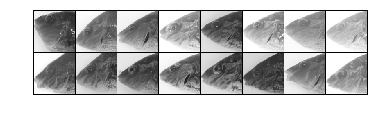

Triplet data example


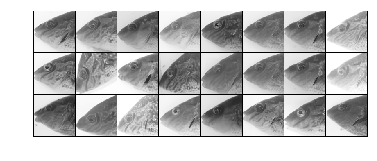

In [26]:
# Contrastive loss
vis_dataloader_contrastive = DataLoader(siamese_dataset_contrastive,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader_contrastive)
print("Contrastive data example")

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))

# Triplet loss
vis_dataloader_triplet = DataLoader(siamese_dataset_triplet,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter_triplet = iter(vis_dataloader_triplet)
print("Triplet data example")

example_batch_triplet = next(dataiter_triplet)
concatenated_triplet = torch.cat((example_batch_triplet[0],example_batch_triplet[1],example_batch_triplet[2]),0)
imshow(torchvision.utils.make_grid(concatenated_triplet))

## Neural Net Definition

In [27]:
class SiameseNetworkContrastive(nn.Module):
    def __init__(self):
        super(SiameseNetworkContrastive, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            # Rectified linear unit (ReLU)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 25))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2



## Triplet loss variant

In [28]:
class SiameseNetworkTriplet(nn.Module):
    def __init__(self):
        super(SiameseNetworkTriplet, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            # Rectified linear unit (ReLU)
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 25))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3


In [29]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive
    
class TripletLoss(torch.nn.Module):
    """
    Triplet loss function
    """
    def __init__(self, margin=1.0, alpha=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.alpha = alpha
    
    
    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, keepdim = True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim = True)
        losses = torch.relu(distance_positive-distance_negative+self.margin)
        
        return losses.mean()

## Training

In [30]:
# Contrastive
train_dataloader_contrastive = DataLoader(siamese_dataset_contrastive,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

# Triplet
train_dataloader_triplet = DataLoader(siamese_dataset_triplet,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [31]:
#Contrastive
net_contrastive = SiameseNetworkContrastive()
criterion_contrastive = ContrastiveLoss()
optimizer = optim.Adam(net_contrastive.parameters(),lr = 0.0005 )

In [32]:
# Triplet
net_triplet = SiameseNetworkTriplet()
criterion_triplet = TripletLoss()
optimizer = optim.Adam(net_triplet.parameters(), lr = 0.00005 )

Epoch number 0
 Current loss 0.8418310880661011



Epoch number 0
 Current loss 0.5832346081733704



Epoch number 1
 Current loss 0.49283647537231445



Epoch number 1
 Current loss 0.5968875885009766



Epoch number 2
 Current loss 0.4072849154472351



Epoch number 2
 Current loss 0.388210266828537



Epoch number 3
 Current loss 0.27713698148727417



Epoch number 3
 Current loss 0.13082163035869598



Epoch number 4
 Current loss 0.21031108498573303



Epoch number 4
 Current loss 0.19056063890457153



Epoch number 5
 Current loss 0.26085883378982544



Epoch number 5
 Current loss 0.15544824302196503



Epoch number 6
 Current loss 0.217244952917099



Epoch number 6
 Current loss 0.2093631625175476



Epoch number 7
 Current loss 0.13687729835510254



Epoch number 7
 Current loss 0.16597262024879456



Epoch number 8
 Current loss 0.1298765242099762



Epoch number 8
 Current loss 0.06704851239919662



Epoch number 9
 Current loss 0.07407169044017792



Epoch number 9
 Current loss 0.08595633506774902



Epoch number 10
 Current loss 0.17627763748168945



Epoch number 10
 Current loss 0.12504373490810394



Epoch number 11
 Current loss 0.08603185415267944



Epoch number 11
 Current loss 0.09140051156282425



Epoch number 12
 Current loss 0.06153059005737305



Epoch number 12
 Current loss 0.11841702461242676



Epoch number 13
 Current loss 0.030304860323667526



Epoch number 13
 Current loss 0.15324874222278595



Epoch number 14
 Current loss 0.05153052881360054



Epoch number 14
 Current loss 0.04293567314743996



Epoch number 15
 Current loss 0.07919174432754517



Epoch number 15
 Current loss 0.03543708845973015



Epoch number 16
 Current loss 0.04814135283231735



Epoch number 16
 Current loss 0.0947532206773758



Epoch number 17
 Current loss 0.023859191685914993



Epoch number 17
 Current loss 0.07096906006336212



Epoch number 18
 Current loss 0.017044059932231903



Epoch number 18
 Current loss 0.04781167209148407



Epoch number 19
 Current loss 0.09967254102230072



Epoch number 19
 Current loss 0.01849103718996048



Epoch number 20
 Current loss 0.013250738382339478



Epoch number 20
 Current loss 0.039707865566015244



Epoch number 21
 Current loss 0.03418005630373955



Epoch number 21
 Current loss 0.0033777430653572083



Epoch number 22
 Current loss 0.03151509910821915



Epoch number 22
 Current loss 0.040200140327215195



Epoch number 23
 Current loss 0.0



Epoch number 23
 Current loss 0.0



Epoch number 24
 Current loss 0.025410816073417664



Epoch number 24
 Current loss 0.0356161892414093



Epoch number 25
 Current loss 0.021936379373073578



Epoch number 25
 Current loss 0.049887098371982574



Epoch number 26
 Current loss 0.016628418117761612



Epoch number 26
 Current loss 0.08385959267616272



Epoch number 27
 Current loss 0.09338170289993286



Epoch number 27
 Current loss 0.08315578103065491



Epoch number 28
 Current loss 0.002084638923406601



Epoch number 28
 Current loss 0.002663247287273407



Epoch number 29
 Current loss 0.02216188982129097



Epoch number 29
 Current loss 0.05276202782988548



Epoch number 30
 Current loss 0.13431893289089203



Epoch number 30
 Current loss 0.05224205553531647



Epoch number 31
 Current loss 0.021029755473136902



Epoch number 31
 Current loss 0.021238982677459717



Epoch number 32
 Current loss 0.0



Epoch number 32
 Current loss 0.0132097527384758



Epoch number 33
 Current loss 0.022042516618967056



Epoch number 33
 Current loss 0.006592795252799988



Epoch number 34
 Current loss 0.02797166258096695



Epoch number 34
 Current loss 0.023460589349269867



Epoch number 35
 Current loss 0.0013397503644227982



Epoch number 35
 Current loss 0.001514378935098648



Epoch number 36
 Current loss 0.007634781301021576



Epoch number 36
 Current loss 0.0856756791472435



Epoch number 37
 Current loss 0.021891094744205475



Epoch number 37
 Current loss 0.008225493133068085



Epoch number 38
 Current loss 0.018370669335126877



Epoch number 38
 Current loss 0.027442514896392822



Epoch number 39
 Current loss 0.0148748978972435



Epoch number 39
 Current loss 0.00809621810913086



Epoch number 40
 Current loss 0.031906623393297195



Epoch number 40
 Current loss 0.019904375076293945



Epoch number 41
 Current loss 0.0038476325571537018



Epoch number 41
 Current loss 0.008944891393184662



Epoch number 42
 Current loss 0.0019381418824195862



Epoch number 42
 Current loss 0.02454715222120285



Epoch number 43
 Current loss 0.014099996536970139



Epoch number 43
 Current loss 0.019061703234910965



Epoch number 44
 Current loss 0.018549159169197083



Epoch number 44
 Current loss 0.00373956561088562



Epoch number 45
 Current loss 0.0



Epoch number 45
 Current loss 0.007950272411108017



Epoch number 46
 Current loss 0.05923403799533844



Epoch number 46
 Current loss 0.0



Epoch number 47
 Current loss 0.013530842959880829



Epoch number 47
 Current loss 0.03220765292644501



Epoch number 48
 Current loss 0.025210663676261902



Epoch number 48
 Current loss 0.0



Epoch number 49
 Current loss 0.009474467486143112



Epoch number 49
 Current loss 0.0



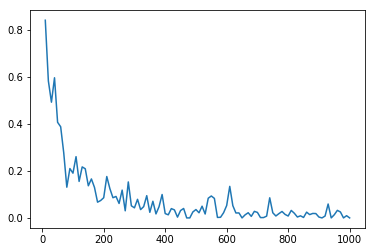

In [33]:
# Triplet
counter_triplet = []
loss_history_triplet = [] 
iteration_number_triplet = 0

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader_triplet,0):
        anchor_img, positive_img, negative_img = data

        optimizer.zero_grad()
        output1,output2,output3 = net_triplet(anchor_img,positive_img,negative_img)
        loss_triplet = criterion_triplet(output1,output2,output3)
        loss_triplet.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_triplet.item()))
            iteration_number_triplet +=10
            counter_triplet.append(iteration_number_triplet)
            loss_history_triplet.append(loss_triplet.item())
show_plot(counter_triplet,loss_history_triplet)

Epoch number 0
 Current loss 1.3631733655929565



Epoch number 0
 Current loss 5.513466835021973



Epoch number 1
 Current loss 8.046429634094238



Epoch number 1
 Current loss 1.4043209552764893



Epoch number 2
 Current loss 2.297057867050171



Epoch number 2
 Current loss 0.7896697521209717



Epoch number 3
 Current loss 0.8442270159721375



Epoch number 3
 Current loss 1.0003936290740967



Epoch number 4
 Current loss 0.9639430642127991



Epoch number 4
 Current loss 0.665052056312561



Epoch number 5
 Current loss 0.9470430612564087



Epoch number 5
 Current loss 0.5852394104003906



Epoch number 6
 Current loss 0.5209517478942871



Epoch number 6
 Current loss 0.5135200023651123



Epoch number 7
 Current loss 0.5075574517250061



Epoch number 7
 Current loss 0.6572474241256714



Epoch number 8
 Current loss 0.4432678818702698



Epoch number 8
 Current loss 0.3789101839065552



Epoch number 9
 Current loss 0.3367406129837036



Epoch number 9
 Current loss 0.37835076451301575



Epoch number 10
 Current loss 0.34630289673805237



Epoch number 10
 Current loss 0.3958145081996918



Epoch number 11
 Current loss 0.48639005422592163



Epoch number 11
 Current loss 0.2387213408946991



Epoch number 12
 Current loss 0.5467801094055176



Epoch number 12
 Current loss 0.31936949491500854



Epoch number 13
 Current loss 0.2560042142868042



Epoch number 13
 Current loss 0.33891773223876953



Epoch number 14
 Current loss 0.4071166217327118



Epoch number 14
 Current loss 0.6735343337059021



Epoch number 15
 Current loss 0.2321009337902069



Epoch number 15
 Current loss 0.31001320481300354



Epoch number 16
 Current loss 0.13969381153583527



Epoch number 16
 Current loss 0.16601163148880005



Epoch number 17
 Current loss 0.15891455113887787



Epoch number 17
 Current loss 0.18884290754795074



Epoch number 18
 Current loss 0.22526930272579193



Epoch number 18
 Current loss 0.12629300355911255



Epoch number 19
 Current loss 0.2201947420835495



Epoch number 19
 Current loss 0.15647763013839722



Epoch number 20
 Current loss 0.13479486107826233



Epoch number 20
 Current loss 0.15053589642047882



Epoch number 21
 Current loss 0.1211022213101387



Epoch number 21
 Current loss 0.1285729855298996



Epoch number 22
 Current loss 0.12347852438688278



Epoch number 22
 Current loss 0.23144540190696716



Epoch number 23
 Current loss 0.1674395501613617



Epoch number 23
 Current loss 0.08735459297895432



Epoch number 24
 Current loss 0.14331132173538208



Epoch number 24
 Current loss 0.10721129924058914



Epoch number 25
 Current loss 0.10827147215604782



Epoch number 25
 Current loss 0.08366356790065765



Epoch number 26
 Current loss 0.10591264814138412



Epoch number 26
 Current loss 0.077207051217556



Epoch number 27
 Current loss 0.0986216738820076



Epoch number 27
 Current loss 0.1338225156068802



Epoch number 28
 Current loss 0.05719172954559326



Epoch number 28
 Current loss 0.11716796457767487



Epoch number 29
 Current loss 0.07635358721017838



Epoch number 29
 Current loss 0.10496609658002853



Epoch number 30
 Current loss 0.05859295278787613



Epoch number 30
 Current loss 0.059889767318964005



Epoch number 31
 Current loss 0.057687826454639435



Epoch number 31
 Current loss 0.07695925980806351



Epoch number 32
 Current loss 0.08968103677034378



Epoch number 32
 Current loss 0.058583635836839676



Epoch number 33
 Current loss 0.05952578783035278



Epoch number 33
 Current loss 0.07817500084638596



Epoch number 34
 Current loss 0.06114093214273453



Epoch number 34
 Current loss 0.09138932824134827



Epoch number 35
 Current loss 0.07745693624019623



Epoch number 35
 Current loss 0.12912213802337646



Epoch number 36
 Current loss 0.08849046379327774



Epoch number 36
 Current loss 0.09067502617835999



Epoch number 37
 Current loss 0.07937205582857132



Epoch number 37
 Current loss 0.08527721464633942



Epoch number 38
 Current loss 0.06660300493240356



Epoch number 38
 Current loss 0.05243240296840668



Epoch number 39
 Current loss 0.03520325571298599



Epoch number 39
 Current loss 0.057645708322525024



Epoch number 40
 Current loss 0.06712682545185089



Epoch number 40
 Current loss 0.042648378759622574



Epoch number 41
 Current loss 0.0605342835187912



Epoch number 41
 Current loss 0.043777309358119965



Epoch number 42
 Current loss 0.061426591128110886



Epoch number 42
 Current loss 0.06103581562638283



Epoch number 43
 Current loss 0.05824151262640953



Epoch number 43
 Current loss 0.039162036031484604



Epoch number 44
 Current loss 0.06898266077041626



Epoch number 44
 Current loss 0.07238079607486725



Epoch number 45
 Current loss 0.047893330454826355



Epoch number 45
 Current loss 0.078829824924469



Epoch number 46
 Current loss 0.055315420031547546



Epoch number 46
 Current loss 0.04580307379364967



Epoch number 47
 Current loss 0.04292641952633858



Epoch number 47
 Current loss 0.04450526088476181



Epoch number 48
 Current loss 0.026399217545986176



Epoch number 48
 Current loss 0.06717096269130707



Epoch number 49
 Current loss 0.10041235387325287



Epoch number 49
 Current loss 0.05316989868879318



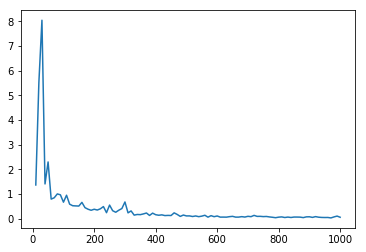

In [239]:
# Contrastive
counter_contrastive = []
loss_history_contrastive = [] 
iteration_number_contrastive = 0


for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader_contrastive,0):
        img0, img1 , label = data
        #img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

        optimizer.zero_grad()
        output1,output2 = net_contrastive(img0,img1)
        loss_contrastive = criterion_contrastive(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number_contrastive +=10
            counter_contrastive.append(iteration_number_contrastive)
            loss_history_contrastive.append(loss_contrastive.item())
show_plot(counter_contrastive,loss_history_contrastive)

In [18]:
## Testing

#The last 100 subjects were held out from the training, and will be used to test. 
#The Distance between each image pair denotes the degree of similarity the model found between the two images. 
#Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [16]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir+"/")
index = random.randint(0,len(folder_dataset_test.imgs))
siamese_dataset = SiameseNetworkTestingDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
dataiter = iter(test_dataloader)

testingAmount = len(folder_dataset_test.imgs)
print("Testing on ", testingAmount, " pictures")
threshold = 7

true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0
skipped=0
samepic=0
notsamepic=0
sameavg=0
notsameavg=0

for i in range(testingAmount):
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    #print("label2",label2)
    #print("label2",label2[0][0].numpy())
    text = "Same"
    same = 1
    if label2[0][0].numpy() == 1.0:
        text = "Not same"
        same = 0
    
    # Use contrastive net
    #output1,output2 = net_contrastive(Variable(x0),Variable(x1))
    # Use triplet net
    output1,output2,_ = net_triplet(Variable(x0), Variable(x1), Variable(x1))
    
    euclidean_distance = F.pairwise_distance(output1, output2)
    euclidean_distance_float = float(euclidean_distance.item())
    skip = 0
    if (euclidean_distance_float < 0.0001):
        skip=1
    elif (euclidean_distance_float > threshold):
        if same:
           false_negative+=1
        else:
            true_negative+=1
    elif (euclidean_distance_float < threshold):
        if same:
            true_positive+=1
        else:
            false_positive+=1
    if skip:
        skipped+=1
    else:
        #imshow(torchvision.utils.make_grid(concatenated),text+' - Dissimilarity: {:.2f}'.format(euclidean_distance.item())+" ")
        
        if same:
            sameavg+=euclidean_distance_float
            samepic+=1
        else:
            notsameavg+=euclidean_distance_float
            notsamepic+=1

print("Total pairs:", true_positive+true_negative+false_positive+false_negative)
print("Same class pairs", samepic)
print("Not same class pairs", notsamepic)
print("True positive", true_positive)
print("False positive", false_positive)
print("True negative", true_negative)
print("False negative", false_negative)
print("Total correct:", true_positive+true_negative)
print("Total wrong:", false_positive+false_negative)
#print("Accuracy:", (true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative))
print("Same accuracy:", true_positive/(true_positive+false_negative))
print("Not same accuracy:", true_negative/(true_negative+false_positive))
print("Same avg dissimilarity", sameavg/samepic)
print("Not same avg dissimilarity", notsameavg/notsamepic)

Testing on  200  pictures


Total pairs: 150
Same class pairs 47
Not same class pairs 103
True positive 33
False positive 50
True negative 53
False negative 14
Total correct: 86
Total wrong: 64
Same accuracy: 0.7021276595744681
Not same accuracy: 0.5145631067961165
Same avg dissimilarity 6.212579757609266
Not same avg dissimilarity 7.620899864770834


In [21]:

def one_shot(dataset_folder):
    testingAmount = len(dataset_folder.imgs)
    correct = 0
    wrong = 0
    for i in range(testingAmount):
        siamese_dataset = SiameseNetworkValidationDataset(imageFolderDataset=dataset_folder,x0Index=i,
                                                transform=transforms.Compose([transforms.Resize((100,100)),
                                                                              transforms.ToTensor()
                                                                              ])
                                               ,should_invert=False)
        
        test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
        dataiter = iter(test_dataloader)
   
        skipped=0        
        samepic = 0
        notsamepic = 0
        low = ["",10]
        
        #for j in range (0):
        for j in range(testingAmount):
            x0,x1,label2 = next(dataiter)
            #output1,output2 = net_contrastive(Variable(x0),Variable(x1))
            output1,output2,_ = net_triplet(Variable(x0), Variable(x1), Variable(x1))
            euclidean_distance = F.pairwise_distance(output1, output2)
            euclidean_distance_float = float(euclidean_distance.item())
            
            if (euclidean_distance_float < 0.00001):
                skipped+=1
                #print("Skipping identical pair")
                continue
            
            text = "Same"
            same = 1
            if label2[0][0].numpy() == 1.0:
                text = "Not same"
                same = 0
                notsamepic+=1
            else:
                samepic+=1
                
            if euclidean_distance_float < low[1]:
                low = [text, euclidean_distance_float]
            
            #if same: # or euclidean_distance_float<0.3:
                #concatenated = torch.cat((x0,x1),0)
                #imshow(torchvision.utils.make_grid(concatenated),text+' - Dissimilarity: {:.2f}'.format(euclidean_distance.item())+" ")
            
        #print("same - not same - ", samepic, notsamepic)
        #print("Lowest:", low)
        if low[0] == "Same":
            correct+=1
        else:
            wrong+=1
    
    print("Correct:", correct,"/",correct+wrong)

# Perform one-shot classification on 10 groups of classes
for i in range(10):
    print(Config.testing_dir+str(i+1))
    folder_dataset_test = dset.ImageFolder(root=Config.testing_dir+str(i+1))
    one_shot(folder_dataset_test)


SiameseNetworks/Siamese-fish/wrassefish/body/r/testing1


Correct: 8 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing2


Correct: 0 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing3


Correct: 3 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing4


Correct: 5 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing5


Correct: 2 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing6


Correct: 2 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing7


Correct: 2 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing8


Correct: 5 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing9


Correct: 7 / 20
SiameseNetworks/Siamese-fish/wrassefish/body/r/testing10


Correct: 4 / 20
